<a href="https://colab.research.google.com/github/FanorC/clusteriing/blob/master/Copy_of_06MBIG_AG1_Introducci%C3%B3n_al_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Introducci√≥n al Clustering

Como problema de partida de ejemplo de como aplicar diferentes algoritmos de clustering vamos a utilizar unos datos del Producto Interior Bruto de los Estados de Estados Unidos en 2009. Los datos est√°n en [Enlace](https://drive.google.com/open?id=1Rb_7eNacmktJM3RqETQmSLysXYjk5EDG)

# Preproceso B√°sico

Antes de empezar cualquier an√°lisis hay que asegurar que las librer√≠as b√°sicas y de uso general (numpy, pandas, etc.) est√°n correctamente importadas. 

Tambi√©n asegurarse de que dentro del entorno est√°n las librer√≠as actualizadas lo cual puede ser imprescindible en algunos momentos, como en este caso sucede con la librer√≠a de visualizaci√≥n *seaborn*

In [0]:
!pip install seaborn --upgrade

Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages (0.9.0)


## Carga de Datos

In [0]:
import matplotlib.pyplot as plt
import numpy
import itertools
import seaborn as sns

En primer lugar cargamos los datos dentro del entorno con las funcionalidades que nos permite Google Colab

Posteriormente utilizamos la librer√≠a [Pandas](https://pandas.pydata.org/) con el fin de poder manejar los datos en una estructura denominada DataFrame


In [0]:
# 0.1 load data from file
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving DatosCluster.csv to DatosCluster.csv
User uploaded file "DatosCluster.csv" with length 14968 bytes


In [0]:
# 0.2 load data in DataFrame
import pandas as pd
import io
df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')),index_col= ['A','B'])




In [0]:
df.head()


C      D      E      F     G     H
A B                                         
1 3  112151  29627  18148  16745  4948  8550
  3   76237   3473   7102  16538   778   918
  3   68951   4411  12609   8692   751  2406
  3   56159    555    902  10002   212  2916
  1   56083   4563   2124   6422   730  3321

Estos datos contienen para cada uno de los estados (*State*) las diferentes cantidades en producto interior bruto dentro de categor√≠as que denominar√≠amos de nivel 2 de agregaci√≥n, es decir, son una desagragci√≥n de niveles superiores. De esta forma encontramos datos como el PIB de Agricultura, Miner√≠a, Construcci√≥n, Comercio, etc. 

Una vez que contamos con el DataFrame de Pandas podr√≠amos analizar qu√© caracter√≠sticas necesitamos y cuales deber√≠amos excluir. En este caso nos vamos a quedar con todas, aunque no todas sean significativas. 

## Transformaciones previas

Como consideraci√≥n previa necesitamos transformar los datos a una misma escala, por ejemplo [0,1]. Esto es as√≠ porque diferentes items de nuestras caracter√≠sticas pueden tener ordenes de dimensi√≥n diferentes. Este proceso no siempre es necesario sobre todo si nos encontramos con variables que ya est√°n en esa esa escala. 

En este caso vamos a optar por utilizar la operaci√≥n [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html), que pretende transformar a una escala con m√≠nimo = 0 y m√°ximo = 1. Esto puede generar cierta distorsi√≥n en los datos pero que puede ser conveniente para conseguir mejores resultados de clustering.  Otras opciones para reducir esta distorsi√≥n ser√≠a utilizar [MaxAbsScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html#sklearn.preprocessing.MaxAbsScaler)

In [0]:
from sklearn import preprocessing 
min_max_scaler = preprocessing.MinMaxScaler()
datanorm = min_max_scaler.fit_transform(df)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [0]:
datanorm

array([[1.00000000e+00, 4.02652397e-01, 1.95576490e-01, 2.74801131e-01,
        1.21129728e-01, 1.78285357e-01],
       [6.79762457e-01, 4.65394932e-02, 7.65168091e-02, 2.71398988e-01,
        1.89839310e-02, 1.90863579e-02],
       [6.14794736e-01, 5.93113026e-02, 1.35874193e-01, 1.42446256e-01,
        1.83225554e-02, 5.01251564e-02],
       ...,
       [5.35007312e-05, 2.01380663e-02, 7.99120472e-02, 2.46532115e-03,
        8.48765432e-02, 5.00625782e-04],
       [0.00000000e+00, 3.90098444e-02, 6.73550557e-02, 6.82072185e-03,
        5.38898687e-03, 1.47267418e-02],
       [0.00000000e+00, 3.78524842e-03, 7.56437479e-02, 2.55998948e-01,
        2.93944738e-04, 1.14100960e-02]])

# An√°lisis de Componentes Principales

El an√°lisis de componentes principales (en espa√±ol ACP, en ingl√©s, PCA) es una t√©cnica utilizada para reducir la dimensionalidad de un conjunto de datos. Intuitivamente la t√©cnica sirve para hallar las causas de la variabilidad de un conjunto de datos y ordenarlas por importancia. T√©cnicamente, PCA busca la proyecci√≥n seg√∫n la cual los datos queden mejor representados en t√©rminos de m√≠nimos cuadrados. PCA se emplea sobre todo en an√°lisis exploratorio de datos y para construir modelos predictivos. 

PCA comporta el c√°lculo de la descomposici√≥n en autovalores de la matriz de covarianza, normalmente tras centrar los datos en la media de cada atributo.
Para ello utilizaremos el procedimiento [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) de scikitlearn

In [0]:
from sklearn import preprocessing 
scaler = preprocessing.StandardScaler()
cliente = scaler.fit_transform(df)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Una de las ventajas del PCA para reducir la dimensionalidad de un grupo de datos, es que retiene aquellas caracter√≠sticas del conjunto de datos que contribuyen m√°s a su varianza, manteniendo un orden de bajo nivel de los componentes principales e ignorando los de alto nivel. 

El objetivo es que esos componentes de bajo orden a veces contienen el aspecto ‚Äúm√°s importante‚Äù de esa informaci√≥n 

En este caso y como nuestro prop√≥sito principal es la visualizaci√≥n utilizaremos √∫nicamente **dos componentes principales**

In [0]:
#2. PCA Estimation
from sklearn.decomposition import PCA
estimator = PCA (n_components = 2)
X_pca = estimator.fit_transform(cliente)
#X_pca


A continuaci√≥n, se muestra el porcentaje de varianza explicado por cada uno de los componentes seleccionados.

En PCA cada componente principal tiene una cierta desviaci√≥n, que en conjunto suman hasta el 100% de la desviaci√≥n total.

Para cada componente principal, un cociente de su varianza con respecto a la varianza total se denomina "proporci√≥n de varianza explicada".

In [0]:
print(estimator.explained_variance_ratio_) 

[0.44082893 0.283764  ]


In [0]:
pd.DataFrame(numpy.matrix.transpose(estimator.components_), columns=['PCA-1', 'PCA-2'], index=df.columns)

PCA-1     PCA-2
C  0.042884  0.527932
D  0.545118  0.083168
E  0.579256 -0.146088
F  0.051189  0.611278
G  0.548640 -0.255233
H  0.248682  0.504207

Finalmente, PCA encuentra un nuevo sistema de coordenadas en el que cada punto tiene un nuevo valor (x,y). Los ejes no significan realmente nada f√≠sico; se eligen para dar a uno de ellos la mejor de las variaciones.

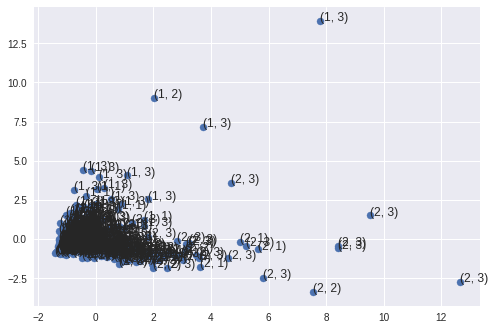

In [0]:
fig, ax = plt.subplots()
ax.scatter(X_pca[:,0], X_pca[:,1] ,s=50)

# anotaci√≥n 
#numbers = numpy.arange(len(X_pca)) # etiquetas num√©ricas
for i in range(0,len(X_pca)):
    ax.annotate(df.iloc[i,:].name, (X_pca[i,0], X_pca[i,1]))

# Clustering Jer√°rquico


Los algoritmos de clustering jer√°rquico se distinguen por generar como resultado una estructura de
grupos organizada en forma de √°rbol jer√°rquico. Este √°rbol, denominado dendrograma es un fiel reflejo de como los clusters se relacionan unos con otros. Dentro de la estructura, el nodo superior o ‚Äúra√≠z‚Äù del √°rbol engloba la totalidad de los elementos de la colecci√≥n, mientras que
los nodos ‚Äúhoja‚Äù representan a los grupos de elementos con similitud m√°xima. Cada nivel intermedio
puede ser visto como la combinaci√≥n de dos agrupaciones del nivel m√°s bajo, o bien, como una parte
de la divisi√≥n de la agrupaci√≥n de nivel m√°s alto.



A continuaci√≥n, ejecutemos un algoritmo de clustering jer√°rquico con el fin de observar como se pueden est√°n organizados los elementos que est√°n bajo estudio, en este caso los estados de Estados Unidos. 

En primer lugar vamos a calcular la matriz de similitud entre los diferentes elementos utilizando para ello la [distancia eucl√≠dea](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html) y la visualizamos utilizando la librer√≠a seaborn y el [gr√°fico de calor](https://seaborn.pydata.org/generated/seaborn.heatmap.html)



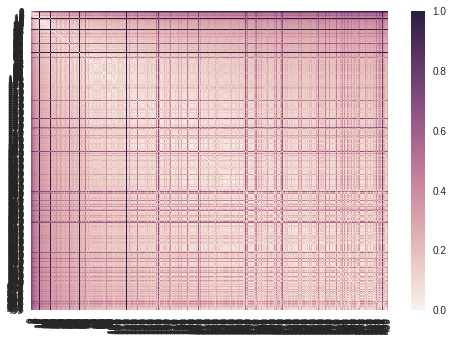

In [0]:
#3. Hierarchical Clustering
# 3.1. Compute the similarity matrix
import sklearn.neighbors
dist = sklearn.neighbors.DistanceMetric.get_metric('euclidean')
matsim = dist.pairwise(datanorm)

# 3.1.1 Visualization
import seaborn as sns; sns.set()
ax = sns.heatmap(matsim,vmin=0, vmax=1  )



Una vez calculada la matriz de similitud pasamos a construir el dendrograma. Para ello hay que decidir que tipo de [distancia intercluster](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html) utilizamos, lo cual depender√° del problema que tengamos que afrontar. En un extremo estar√° el enlace simple que permitir√° manejar f√°cilmente elementos especiales (*outliers*) y clusters de muy diversa forma, pero que nos ofrecer√° grupos poco balanceados. En el otro extremo el enlace completo nos ofrecer√° agrupaciones m√°s equlibradas pero que supondr√°n la divisi√≥n de grupos mayoritarios. De forma intermedia tendremos otros √≠ndices como Ward o Average. 
paa ver c√≥mo se distribuyen los datos.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


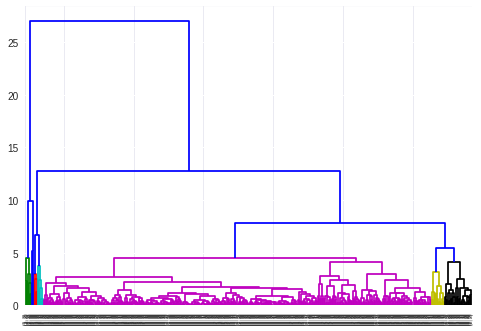

<Figure size 576x396 with 0 Axes>

In [0]:
# 3.2. Building the Dendrogram	
from scipy import cluster
clusters = cluster.hierarchy.linkage(matsim, method = 'complete')
# http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.dendrogram.html
cluster.hierarchy.dendrogram(clusters, color_threshold=5, labels = df.index)

# 3.2.1 Visualization
f = plt.figure()
plt.show()
f.savefig( "test.png")
files.download('test.png')


Aunque aqu√≠ el corte m√°s que lineal tendr√≠a que hacerse ad-hoc, es decir, a partir de un corte con m√°s granularidad (m√°s grupos) deber√≠amos entonces reagrupar clusters que sean muy similares entre s√≠.

De todos modos vamos a cortar a un nivel l√≥gico a pesar de darnos algunos valores at√≠picos (grupos de un solo elemento)

Por ejemplo, un corte a nivel 5 con un enlace completo da lugar a 5 grupos, alguno de ellos con muy pocos elementos 



In [0]:
cut =7 # !!!! ad-hoc
labels = cluster.hierarchy.fcluster(clusters, cut , criterion = 'distance')

labels

array([1, 3, 3, 5, 5, 3, 5, 5, 5, 5, 1, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 2,
       4, 4, 1, 4, 1, 4, 4, 4, 4, 5, 5, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4,
       4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 5, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 5, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       3, 4, 4, 5, 4, 4, 4, 5, 4, 4, 4, 4, 4, 5, 5, 4, 4, 4, 4, 4, 4, 4,
       4, 5, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4,

Una vez terminado el clustering podemos aplicar ciertas m√©tricas de calidad del mismo como el [coeficiente Silohuette] (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)



In [0]:
# tratamos el cluster -1 como cluster de outliers
from sklearn import metrics
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(datanorm, labels))

Estimated number of clusters: 5
Silhouette Coefficient: 0.456


Y podr√≠amos comenzar con la caracter√≠zaci√≥n de los grupos, en primer lugar visualizandolos utilizando la proyecci√≥n PCA

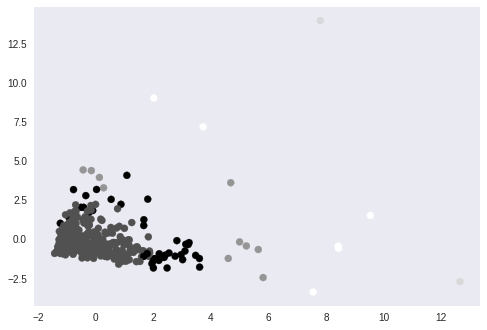

In [0]:
#plotting orginal points with color related to label
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels,s=50)
plt.grid()
plt.show()

Y luego obteniendo estad√≠sticos b√°sicos que nos permitan interpretar que significa cada grupo

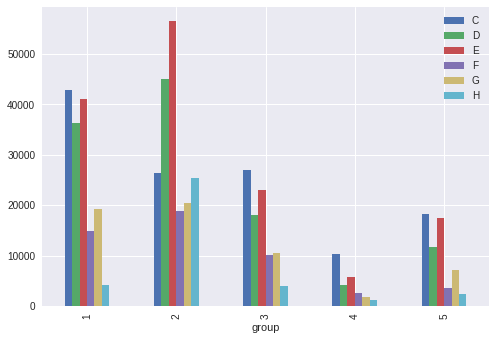

In [0]:
df['group'] = labels


res = df[['C','D', 'E', 'F','G','H','group']].groupby(('group')).mean()
res.plot(kind='bar', legend=True)




Y podemos utilizar filtros para saber que estados pertenecen a cada grupo

In [0]:
df[df['group'] == 1]

C      D      E      F      G     H  group
A B                                                 
1 3  112151  29627  18148  16745   4948  8550      1
2 3   44466  54259  55571   7782  24171  6465      1
  3   35942  38369  59598   3254  26701  2017      1
1 2   32717  16784  13626  60869   1272  5609      1
2 3   22925  73498  32114    987  20070   903      1
  2    8565   4980  67298    131  38102  1215      1

O sacar todos los estad√≠sticos basicos para luego pasarlo a otra herramienta (Excel)

In [0]:
res = df[['C','D', 'E', 'F','G','H','group']].groupby('group').describe()
res

C                                                          \
       count          mean           std      min       25%      50%   
group                                                                  
1        6.0  42794.333333  36133.326632   8565.0  25373.00  34329.5   
2        2.0  26482.000000  14658.323574  16117.0  21299.50  26482.0   
3       10.0  27059.100000  28865.597057     85.0   6900.00  11716.5   
4      382.0  10397.602094   8955.160697      3.0   3098.50   8130.0   
5       40.0  18198.150000  19301.583988    161.0   2433.25   7870.0   

                               D                 ...           G           \
            75%       max  count          mean   ...         75%      max   
group                                            ...                        
1      42335.00  112151.0    6.0  36252.833333   ...     26068.5  38102.0   
2      31664.50   36847.0    2.0  45073.500000   ...     30680.0  40827.0   
3      48654.75   76237.0   10.0  18068.300000   ...     18828.0  24231.0   
4      15612.00   40721.0  382.0   4174.780105   ...      3195.5  10069.0   
5      33837.00   56159.0   40.0  11681.100000   ...     12411.0  17120.0   

           H                                                                   \
       count          mean           std     min       25%      50%       75%   
group                                                                           
1        6.0   4126.500000   3179.670282   903.0   1415.50   3813.0   6251.00   
2        2.0  25443.500000  31819.098047  2944.0  14193.75  25443.5  36693.25   
3       10.0   4092.700000   4597.793361   918.0   1668.75   2598.0   4558.25   
4      382.0   1191.259162   1154.060745     3.0    383.00    836.0   1625.50   
5       40.0   2482.725000   3205.364662     3.0    725.75   1514.5   2971.25   

                
           max  
group           
1       8550.0  
2      47943.0  
3      16523.0  
4       7844.0  
5      14472.0  

[5 rows x 48 columns]

In [0]:
res.to_excel('res.xlsx')
files.download('res.xlsx')

Para finalizar buscamos una visualizaci√≥n un poco especial con [seaborn.clustermap](https://seaborn.pydata.org/generated/seaborn.clustermap.html)

# K-means

 El algoritmo k-means se basa en la idea de que un punto central puede representar un
cl√∫ster, este punto es lo que se denomina centroide. Normalmente este punto es la media o mediana
de un grupo de puntos y por lo tanto puede no ser un elemento del conjunto a analizar. El algoritmo
k-means establece una distancia entre los elementos mediante la selecci√≥n de un n√∫mero predefinido de centroides. 


K-means utiliza estos centroides preseleccionados como ‚Äúsemillas‚Äù en el proceso de construir los cl√∫steres. Para ello, se asigna un cl√∫ster a cada centroide, en un proceso iterativo. El cl√∫ster asignado a cada centroide es el m√°s ‚Äúcercano‚Äù a √©ste, y la distancia se mide entre el elemento para ser
incluido y el valor medio para todos los cl√∫steres. Tal y como se ha mencionado anteriormente, el
objetivo del proceso del algoritmo k- means es el de minimizar una funci√≥n de error o distancia, por
ejemplo, la suma de errores al cuadrado.

### Parametrizaci√≥n



En primer lugar vamos a establecer los par√°metros que vamos a considerar por defecto

In [0]:
# parameters
init = 'random' # initialization method 

# to run 10 times with different random centroids 
# to choose the final model as the one with the lowest SSE
iterations = 10

# maximum number of iterations for each single run
max_iter = 300 

# controls the tolerance with regard to the changes in the 
# within-cluster sum-squared-error to declare convergence

tol = 1e-04 

 # random seed
random_state = 0

Vamos a elegir K dependiendo de los valores que tome el clustering en cuanto a Distorsi√≥n (SSE) y Silhouette desde k = 2 a k = 11

*En este caso adem√°s vamos a optar por hacer el clustering sobre los datos proyectados mediante PCA*

In [0]:
from sklearn.cluster import KMeans
from sklearn import metrics

distortions = []
silhouettes = []

for i in range(2, 11):
    km = KMeans(i, init, n_init = iterations ,max_iter= max_iter, tol = tol,random_state = random_state)
    labels = km.fit_predict(X_pca)
    distortions.append(km.inertia_)
    silhouettes.append(metrics.silhouette_score(datanorm, labels))

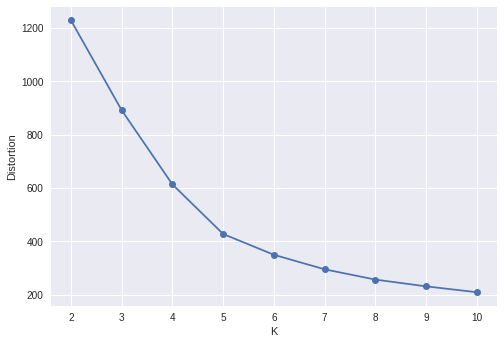

In [0]:
plt.plot(range(2,11), distortions, marker='o')
plt.xlabel('K')
plt.ylabel('Distortion')
plt.show()

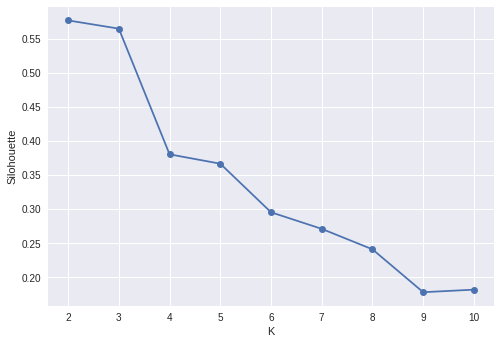

In [0]:
plt.plot(range(2,11), silhouettes , marker='o')
plt.xlabel('K')
plt.ylabel('Silohouette')
plt.show()

### Ejecuci√≥n del Algoritmo

Vamos a seleccionar k = 4 con el fin de ejecutar el clustering

In [0]:
k = 5

km = KMeans(k, init, n_init = iterations ,
            max_iter= max_iter, tol = tol, random_state = random_state)


y_km = km.fit_predict(X_pca)

Vamos a calcular los valores finales de las m√©tricas del algoritmo

In [0]:
from sklearn import metrics
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(datanorm, y_km))
      
print('Distortion: %.2f' % km.inertia_)

Silhouette Coefficient: 0.367
Distortion: 427.24


Y vamos a visualizar los resultados


In [0]:
km.labels_


array([1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 1,
       4, 4, 3, 4, 1, 0, 2, 0, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 4, 2, 0, 4,
       0, 0, 0, 3, 0, 0, 4, 0, 4, 4, 0, 4, 2, 4, 4, 0, 3, 0, 4, 4, 0, 0,
       4, 2, 0, 0, 0, 2, 0, 0, 4, 0, 0, 0, 4, 0, 2, 4, 0, 4, 0, 0, 4, 0,
       0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0,
       4, 4, 0, 4, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 4, 0, 0, 2, 0, 0, 0, 2,
       0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 0, 0, 2, 0, 0, 0, 0,
       0, 2, 0, 3, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 4, 4, 2, 0, 0, 0,
       0, 0, 4, 0, 2, 0, 2, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 4, 0, 0, 2, 0, 0, 0, 0, 0, 3, 4,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 0, 0, 0, 0, 2, 0,
       3, 0, 2, 2, 0, 0, 0, 4, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0,
       0, 2, 0, 0, 0, 4, 2, 2, 0, 0, 0, 0, 0, 0, 2,

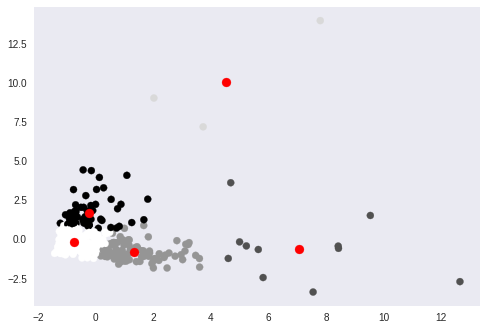

In [0]:
#plotting orginal points with color related to label
plt.scatter(X_pca[:,0], X_pca[:,1], c=km.labels_,s=50)
# plotting centroids
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], c='red',s=80)
# 
plt.grid()
plt.show()
      

Y a proceder a su interpretaci√≥n

In [0]:
labels

array([2, 3, 3, 3, 3, 3, 1, 1, 1, 1, 4, 3, 1, 1, 1, 1, 9, 1, 1, 1, 1, 2,
       1, 1, 4, 1, 2, 9, 7, 9, 1, 3, 3, 7, 1, 1, 3, 9, 7, 9, 1, 7, 9, 1,
       7, 9, 9, 3, 9, 9, 1, 9, 3, 1, 9, 1, 7, 1, 1, 9, 4, 9, 7, 1, 9, 9,
       1, 5, 9, 7, 9, 7, 9, 9, 1, 9, 7, 9, 1, 9, 7, 1, 9, 1, 9, 9, 1, 9,
       0, 7, 9, 7, 9, 3, 9, 9, 9, 9, 9, 1, 9, 9, 9, 7, 9, 9, 6, 1, 6, 9,
       1, 1, 6, 1, 6, 0, 9, 6, 4, 9, 0, 7, 9, 9, 1, 9, 9, 7, 7, 0, 9, 5,
       9, 0, 0, 1, 0, 0, 0, 9, 9, 6, 9, 0, 7, 9, 9, 0, 6, 8, 9, 0, 6, 6,
       0, 5, 6, 5, 8, 6, 9, 0, 9, 9, 9, 7, 9, 6, 9, 9, 3, 1, 8, 9, 0, 6,
       0, 0, 1, 0, 8, 0, 7, 0, 9, 7, 7, 9, 0, 9, 9, 0, 9, 5, 6, 0, 9, 0,
       0, 0, 0, 6, 8, 0, 9, 0, 5, 0, 9, 1, 0, 0, 8, 7, 9, 0, 0, 6, 4, 1,
       9, 0, 9, 6, 6, 0, 6, 6, 9, 9, 9, 6, 6, 6, 0, 0, 6, 0, 0, 8, 0, 0,
       9, 0, 0, 0, 6, 1, 0, 0, 0, 0, 6, 0, 9, 8, 0, 7, 0, 0, 9, 0, 6, 6,
       5, 0, 8, 8, 9, 0, 0, 7, 9, 0, 0, 8, 0, 8, 5, 0, 8, 0, 6, 0, 8, 0,
       6, 5, 9, 6, 9, 1, 5, 6, 0, 0, 0, 6, 0, 6, 8,

# DBSCAN



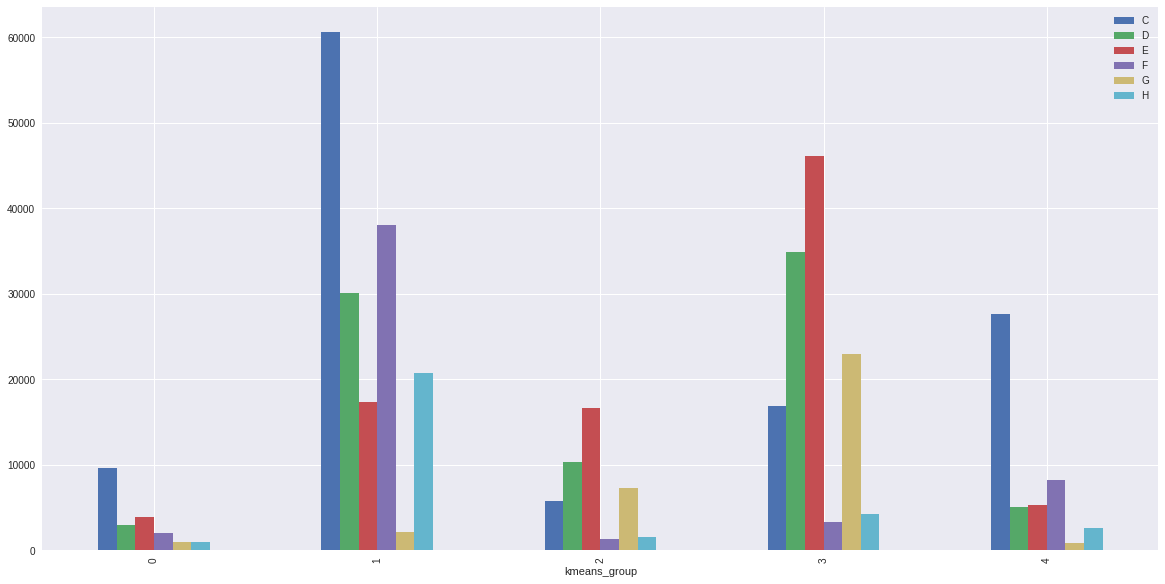

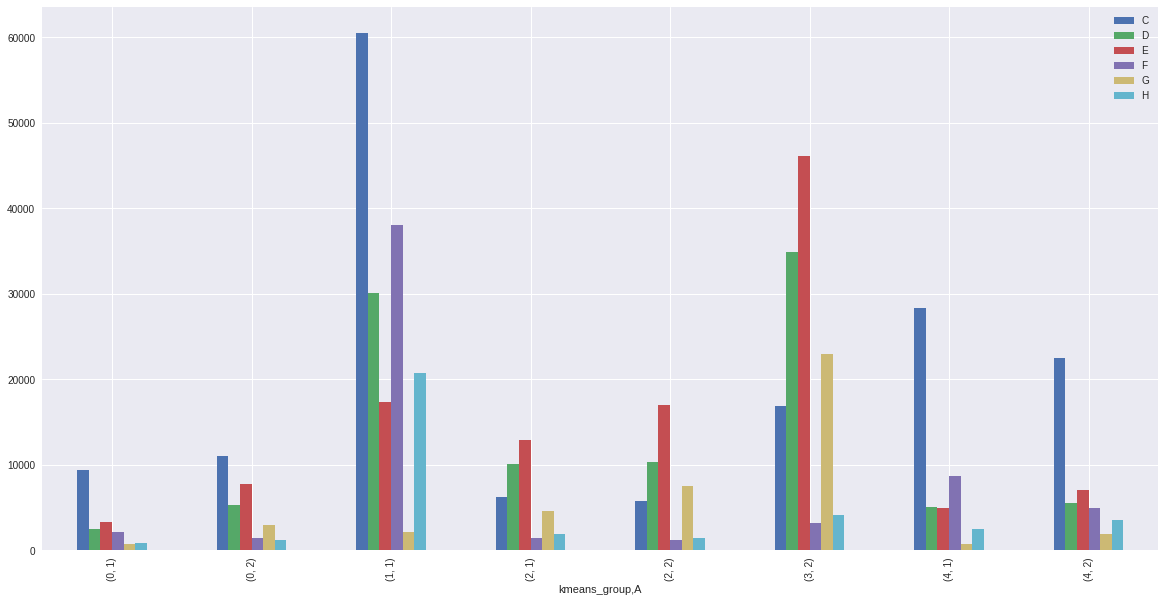

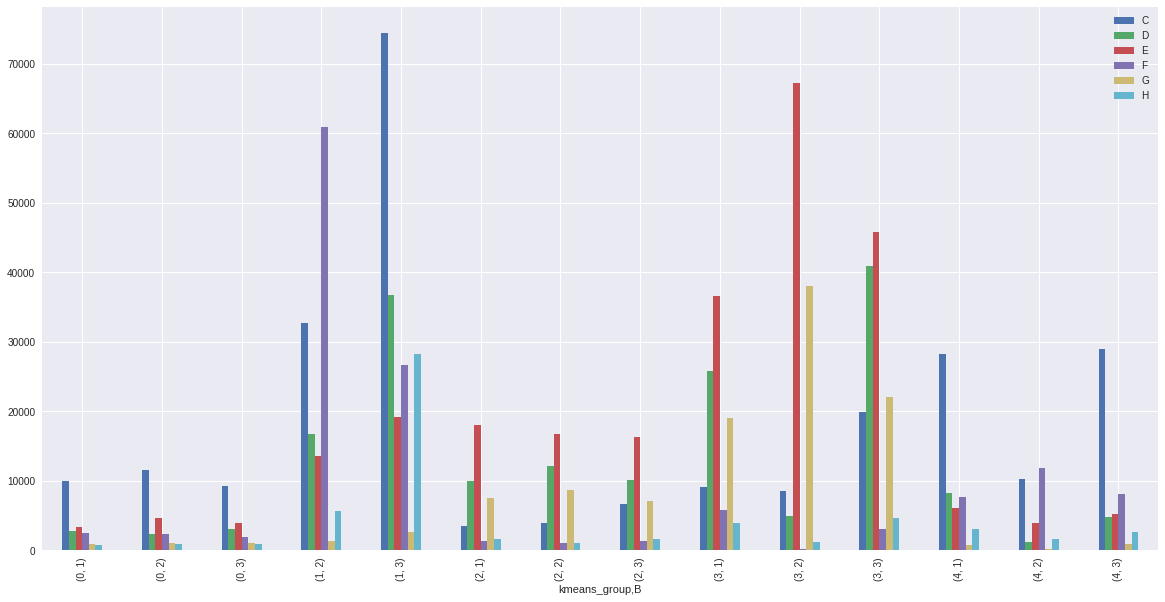

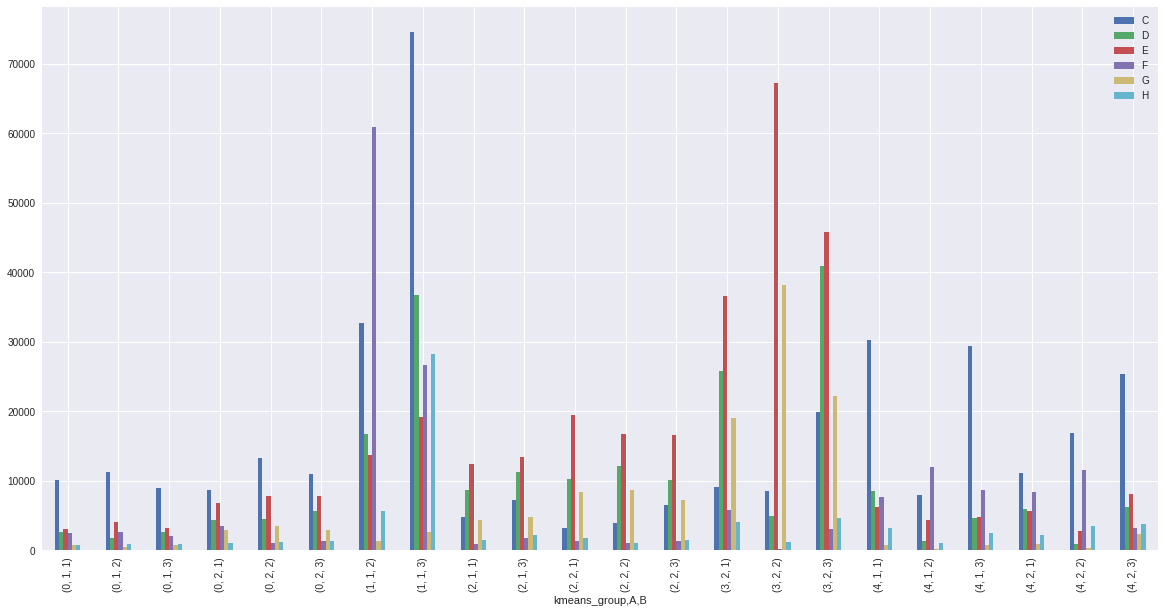

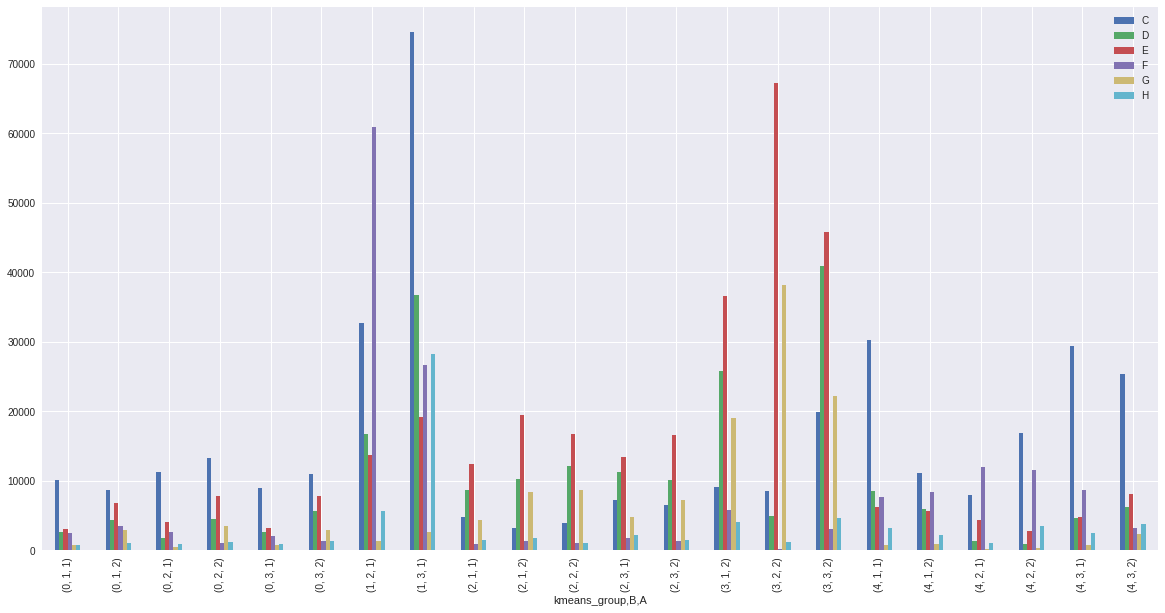

In [0]:
df['kmeans_group'] = km.labels_


res = df[['C', 'D','E','F','G','H', 'kmeans_group']].groupby(('kmeans_group')).mean()
res.plot(kind='bar', legend=True, figsize=(20, 10) )





res1 = df[['C', 'D','E','F','G','H', 'kmeans_group']].groupby(('kmeans_group' ,'A')).mean()
res1.plot(kind='bar', legend=True, figsize=(20, 10) )


res3 = df[['C', 'D','E','F','G','H', 'kmeans_group']].groupby(('kmeans_group',  'B')).mean()
res3.plot(kind='bar', legend=True, figsize=(20, 10) )

res4 = df[['C', 'D','E','F','G','H', 'kmeans_group']].groupby(('kmeans_group' ,'A', 'B')).mean()
res4.plot(kind='bar', legend=True, figsize=(20, 10) )


res5 = df[['C', 'D','E','F','G','H', 'kmeans_group']].groupby(('kmeans_group' ,'B', 'A')).mean()
res5.plot(kind='bar', legend=True, figsize=(20, 10) )





La idea clave de los algoritmos de clustering basados en densidad es que asumen que los grupos
est√°n definidos en √°reas de gran densidad de datos. Las zonas pocos densas separan los grupos.
DBSCAN es el primer algoritmo que se defini√≥ basado en la densidad describi√©ndose los conceptos
de punto central, borde y ruido. Los puntos centrales poseen un √°rea de vecindad para
un determinado radio que tiene por lo menos un n√∫mero m√≠nimo de puntos, o sea que su √°rea de
vecindad excede un determinado umbral

### Parametrizaci√≥n


Dibujamos en un gr√°fico la distancia mas corta al vecino para obtener el epsilon a utilizar en DBSCAN.
Como MintPts ponemos un n√∫mero bajo, considerando que tener 3 estados parecidos es ya sin√≥nimo de un √°rea densa. 

NOTA: Para realizar estos c√°lculos nos vamos a apoyar en la matriz de similitud calculada para la ejecuci√≥n del Algoritmo Jer√°rquico


In [0]:
minPts=3
from sklearn.neighbors import kneighbors_graph
A = kneighbors_graph(datanorm, minPts, include_self=False)
Ar = A.toarray()

seq = []
for i,s in enumerate(datanorm):
    for j in range(len(datanorm)):
        if Ar[i][j] != 0:
            seq.append(matsim[i][j])
            
seq.sort()
# establecer intervalo ejes
fig = plt.figure()
ax = fig.gca()
ax.set_xticks(numpy.arange(0, 150, 20))
ax.set_yticks(numpy.arange(0, 3, 0.1))

plt.plot(seq)


plt.show()

Aunque se podr√≠a probar con otras opciones vamos a optar por probar  a realizar diferntes clusters desde 0.2 a 0.7 con intervalos de 0.1. De todas formas la disposici√≥n de los datos har√° que DBSCAN √∫nicamente aisle una zona densa de aquellos elementos que considera *outliers*

## Ejecuci√≥n

In [0]:
from sklearn.cluster import DBSCAN

for eps in numpy.arange(0.2, 2.4, 0.1):
  db = DBSCAN(eps=0.3, min_samples=minPts).fit(datanorm)
  core_samples_mask = numpy.zeros_like(db.labels_, dtype=bool)
  core_samples_mask[db.core_sample_indices_] = True
  labels = db.labels_
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  
labels

Visualizamos los resultados

In [0]:
#plotting orginal points with color related to label
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels,s=50)
plt.grid()
plt.show()

Y aunque podr√≠amos proceder a su intepretaci√≥n en este caso lo que vamos a hacer es identificar aquellos elementos que son outliers

In [0]:
df['dbscan_group'] = labels

df[df['dbscan_group'] == -1]

#  Expectation - Maximization

En el clustering probabil√≠stico se parte de un conjunto de un conjunto de observaciones o muestras
las cuales son independientes e id√©nticamente distribuidas aleatoriamente. En este tipo de algoritmos
se asume que la probabilidad de que dado un cluster ùëÜùëñ el conjunto de muestras ùëå pertenezca a ella,
tiene una forma param√©trica conocida, determinada por un conjunto de par√°metros Œ∏ùëñ. Este conjunto
de par√°metros depender√° de la distribuci√≥n elegida. El objetivo en cuesti√≥n es buscar aquellas
distribuciones que mejor generan el conjunto de datos, y para ello se utiliza la informaci√≥n obtenida
por las muestras observadas para estimar de forma √≥ptima los par√°metros Œ∏ùëñ de cada distribuci√≥n
generadora.

En este caso vamos a optar por utilizar una combinaci√≥n de Gaussianas bajo el Gaussian Mixture Model.

Con el fin de determinar el n√∫mero de clusters (*k*) vamos a utilizar en este caso el [BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion) Bayesian Information Criterion. Este criterio compara el ajuste de diferentes modelos pero penalizando la complejidad del modelo (n√∫mero de par√°metros). El modelo con el menor valor de BIC es el que debe ser elegido

In [0]:
from sklearn.mixture import GaussianMixture

lowest_bic = numpy.infty
bic = []
best_cv = 'full'
best_k = 3
cv_types = ['spherical', 'tied', 'diag', 'full']
n_components_range = range(1, 7)
for cv_type in cv_types:
    for k in range(1, 7):
        gmm = GaussianMixture(n_components=k, covariance_type=cv_type, init_params='random')
        gmm.fit(X_pca)
        bic.append(gmm.bic(X_pca))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_cv = cv_type
            best_k = k
            
print ("Mejor valor K", best_k, "Mejor tipo de Covarianza", best_cv)

Adem√°s de Calcular el mejor valor de K vamos adem√°s a graficar los resultados para obtener m√°s informaci√≥n sobre el an√°lisis realizado de acuerdo a lo recomendado en [enlace](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html)

In [0]:
# Plot the BIC scores
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
bars = []
plt.figure(figsize=(18, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = numpy.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([min(bic) * 1.01 - .01 * max(bic), max(bic)])
plt.title('BIC score per model')
xpos = numpy.mod(numpy.argmin(bic), len(n_components_range)) + .65 +\
    .2 * numpy.floor(numpy.argmin(bic) / len(n_components_range))
plt.text(xpos, min(bic) * 0.97 + .03 * max(bic), '*', fontsize=14)
spl.set_xlabel('N√∫mero de componentes')
spl.legend([b[0] for b in bars], cv_types)

Ejecutaremos el algoritmo con los mejores par√°metros obtenidos

In [0]:
EM = GaussianMixture(n_components=best_k, covariance_type=best_cv, init_params='random')
EM.fit(X_pca)
labels =  EM.predict(X_pca)
n_clusters = best_k - (1 if -1 in labels else 0)

Una vez ejecutado el m√≥delo √≥ptimo del algoritmo visualizamos los resultados utilizando la representaci√≥n PCA

In [0]:
#plotting orginal points with color related to label
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels,s=50)
plt.grid()
plt.show()

Y procedemos a la interpretaci√≥n de los resultados

In [0]:
df['em_group'] = labels


res = df[['Finance', 'Mining', 'Manufacturing', 'em_group']].groupby(('em_group')).mean()
res.plot(kind='bar', legend=True)